In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial import distance

In [17]:
model_names = ['HAR_RV', 'LAG', 'Linear', 'PCA_Linear', 'Random_Forest', 'Gradient_Boosting']

desktop_path = Path('.')

# Calculate performance metrics for each model
def calculate_performance_metrics():
    
    metrics = []

    for model in model_names:

        y_pred = pd.read_csv(f'{model}_predictions.csv', index_col=0)
            
        actual = pd.read_csv('real_volatility.csv')
        y_true = actual.reindex(index=y_pred.index) 

        Y, Ŷ = np.exp(y_true.values), y_pred.values
        eps = 1e-12

        rmspe = np.sqrt(np.mean(((Ŷ - Y) / (Y + eps))**2, axis=0))
        ratio = (Y + eps) / (Ŷ + eps)
        qlike = np.mean(ratio - np.log(ratio) - 1, axis=0)
        mape = np.mean(np.abs(Ŷ - Y) / (Y + eps), axis=0)
        rmse = np.sqrt(np.mean((Ŷ - Y)**2, axis=0))

        for stock, RMSE, RMSPE, QLIKE, MAPE in zip(y_true.columns, rmse, rmspe, qlike, mape):
            metrics.append({
                "Model": model,
                "Stock": stock,
                "RMSE": RMSE,
                "RMSPE": RMSPE,
                "QLIKE": QLIKE,
                "MAPE": MAPE
            })

    summary_df = pd.DataFrame(metrics)
    summary_df1 = summary_df.groupby("Model")[["RMSE", "RMSPE", "QLIKE", "MAPE"]].mean().round({
        "RMSE": 6,
        "RMSPE": 2,
        "QLIKE": 6,
        "MAPE": 2
    })

    print("\nModel Performance")
    print(summary_df1)
    
# Run the code
calculate_performance_metrics()


Model Performance
                       RMSE  RMSPE     QLIKE  MAPE
Model                                             
Gradient_Boosting  0.983840   0.65  0.200048  0.47
HAR_RV             0.964477   0.63  0.180036  0.45
LAG                1.016574   0.77  0.215881  0.51
Linear             0.977705   0.65  0.191284  0.46
PCA_Linear         0.956301   0.54  0.178410  0.40
Random_Forest      0.960064   0.59  0.180799  0.43


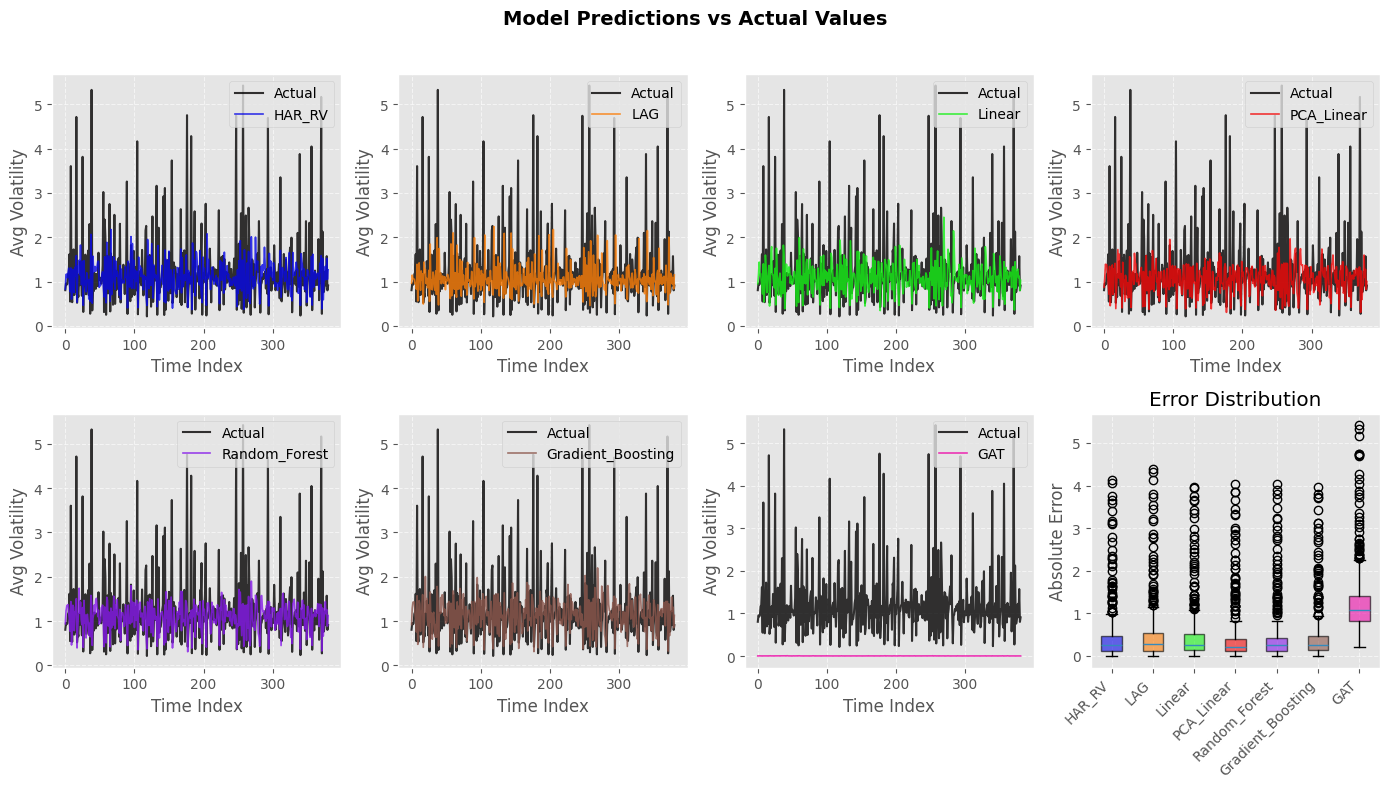

In [7]:

model_names = ['HAR_RV', 'LAG', 'Linear', 'PCA_Linear', 'Random_Forest', 'Gradient_Boosting', 'GAT']
desktop_path = Path('.')

def load_and_align_data():
    model_preds = {}
    shared_stocks = None
    shared_dates = None

    # Load all models
    for model in model_names:
        if model == 'GAT':
            preds = pd.read_csv('GAT_prediction_panel.csv', index_col=0)
        else:
            preds = pd.read_csv(f'{model}_predictions.csv', index_col=0)
        
        model_preds[model] = preds
        
        if shared_stocks is None:
            actual = pd.read_csv('real_volatility.csv')
            shared_stocks = list(set(preds.columns).intersection(set(actual.columns)))
            shared_dates = preds.index.tolist()
        else:
            shared_stocks = list(set(shared_stocks).intersection(set(preds.columns)))
            shared_dates = list(set(shared_dates).intersection(set(preds.index.tolist())))

    aligned_actual = actual.reindex(index=shared_dates)
    aligned_actual1 = np.exp(aligned_actual)
    
    return model_preds, aligned_actual1, shared_stocks, shared_dates

def create_comparison_plots():
    model_preds, actual, shared_stocks, shared_dates = load_and_align_data()
    
    plt.style.use('ggplot')
    colors = ["#0707E7", "#FB7D07", "#15F115", "#F40808", "#8518EA", '#8C564B', "#ED09A8"]
    
    fig, axes = plt.subplots(2, 4, figsize=(14, 8))
    axes = axes.flatten()
    
    # Calculate average across stocks
    avg_actual = actual.loc[shared_dates, shared_stocks].mean(axis=1).values
    x_indices = np.arange(len(avg_actual))
    model_errors = {}
    
    for idx, model in enumerate(model_names):
        if idx >= len(axes) - 1:
            break
            
        # Get model predictions and calculate average
        model_data = model_preds[model].loc[shared_dates, shared_stocks]
        avg_pred = model_data.mean(axis=1).values
        
        
        # Store errors for boxplot
        errors = np.abs(avg_pred - avg_actual)
        model_errors[model] = errors
        
        # Plot
        axes[idx].plot(x_indices, avg_actual, '-', color='#030202', 
                      linewidth=1.5, label='Actual', alpha=0.8)
        axes[idx].plot(x_indices, avg_pred, '-', color=colors[idx % len(colors)], 
                      linewidth=1.2, label=model, alpha=0.8)
        
        
        axes[idx].set_xlabel('Time Index')
        axes[idx].set_ylabel('Avg Volatility')
        axes[idx].legend(loc='upper right')
        axes[idx].grid(True, linestyle='--', alpha=0.6)
    
    # Error distribution boxplot
    if model_errors:
        boxplot_data = [errors for errors in model_errors.values()]
        boxplot = axes[-1].boxplot(boxplot_data, patch_artist=True)
        
        for i, box in enumerate(boxplot['boxes']):
            box.set(facecolor=colors[i % len(colors)], alpha=0.6)
        
        axes[-1].set_title('Error Distribution')
        axes[-1].set_ylabel('Absolute Error')
        axes[-1].set_xticklabels(model_errors.keys(), rotation=45, ha='right')
        axes[-1].grid(True, linestyle='--', alpha=0.6)
    
    plt.suptitle('Model Predictions vs Actual Values', fontsize=14, y=0.98, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(desktop_path / "model_comparisons.png", dpi=300, bbox_inches='tight')
    plt.show()

# Run the code
create_comparison_plots()

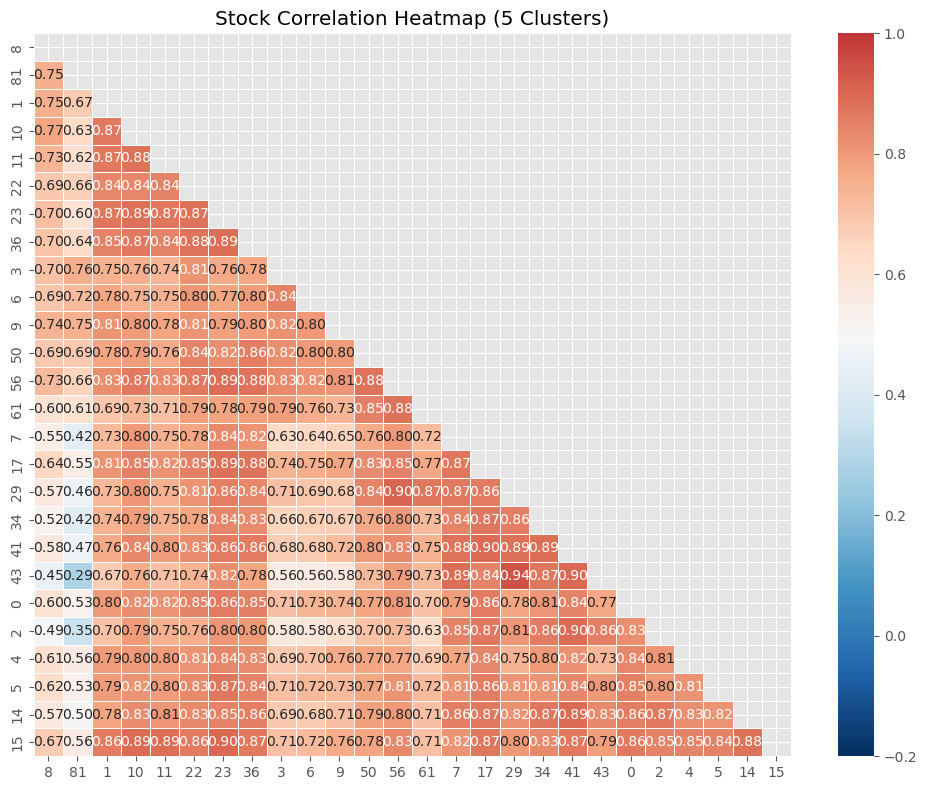

In [4]:
desktop_path = Path('.')

def visualize_stock_correlation():
    # Load data
    volatility_data = pd.read_csv('real_volatility.csv', index_col=0)

    correlation_matrix = volatility_data.corr()
    
    # Perform clustering to select 
    dist = distance.squareform(1 - correlation_matrix.abs())
    linkage = hierarchy.linkage(dist, method='ward')
    clusters = hierarchy.fcluster(linkage, 5, criterion='maxclust')
    
    # Select stocks from each cluster 
    selected_stocks = []
    for cluster_id in range(1, max(clusters)+1):
        cluster_stocks = [stock for i, stock in enumerate(correlation_matrix.index) if clusters[i] == cluster_id]
        selected_stocks.extend(cluster_stocks[:6])  
    
    if len(selected_stocks) > 30:
        selected_stocks = selected_stocks[:30]
    
    subset_corr = correlation_matrix.loc[selected_stocks, selected_stocks]
    
    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(subset_corr, dtype=bool))
    sns.heatmap(subset_corr, cmap='RdBu_r', vmin=-0.2, vmax=1.0, 
                center=0.5, annot=True, fmt='.2f', linewidths=0.5, mask=mask)
    plt.title('Stock Correlation Heatmap (5 Clusters)')
    
    plt.tight_layout()
    plt.savefig(desktop_path / "correlation_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

# Run the code
visualize_stock_correlation()